In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from keras import Sequential
from keras import layers
from keras import callbacks

Using TensorFlow backend.


In [5]:
# Import labels (for the whole dataset, both training and testing)
y = pd.read_csv('dataset/actual.csv')
print(y.shape)
y.head()

(72, 2)


,patient,cancer
0,1,ALL
1,2,ALL
2,3,ALL
3,4,ALL
4,5,ALL


In [6]:
y['cancer'].value_counts()

ALL    47
AML    25
Name: cancer, dtype: int64

In [7]:
y = y.replace({'ALL':0,'AML':1})
labels = ['ALL', 'AML']

In [8]:
# Import training data
df_train = pd.read_csv('dataset/data_set_ALL_AML_train.csv')
print(df_train.shape)

# Import testing data
df_test = pd.read_csv('dataset/data_set_ALL_AML_independent.csv')
print(df_test.shape)

(7129, 78)
(7129, 70)


In [9]:
df_train.head()

,Gene Description,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,5,call.4,6,call.5,7,call.6,8,call.7,9,call.8,10,call.9,11,call.10,12,call.11,13,call.12,14,call.13,15,call.14,16,call.15,17,call.16,18,call.17,19,call.18,20,call.19,21,call.20,22,call.21,23,call.22,24,call.23,25,call.24,26,call.25,27,call.26,34,call.27,35,call.28,36,call.29,37,call.30,38,call.31,28,call.32,29,call.33,30,call.34,31,call.35,32,call.36,33,call.37
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,A,-139,A,-76,A,-135,A,-106,A,-138,A,-72,A,-413,A,5,A,-88,A,-165,A,-67,A,-92,A,-113,A,-107,A,-117,A,-476,A,-81,A,-44,A,17,A,-144,A,-247,A,-74,A,-120,A,-81,A,-112,A,-273,A,-20,A,7,A,-213,A,-25,A,-72,A,-4,A,15,A,-318,A,-32,A,-124,A,-135,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,A,-73,A,-49,A,-114,A,-125,A,-85,A,-144,A,-260,A,-127,A,-105,A,-155,A,-93,A,-119,A,-147,A,-72,A,-219,A,-213,A,-150,A,-51,A,-229,A,-199,A,-90,A,-321,A,-263,A,-150,A,-233,A,-327,A,-207,A,-100,A,-252,A,-20,A,-139,A,-116,A,-114,A,-192,A,-49,A,-79,A,-186,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,A,-1,A,-307,A,265,A,-76,A,215,A,238,A,7,A,106,A,42,A,-71,A,84,A,-31,A,-118,A,-126,A,-50,A,-18,A,-119,A,100,A,79,A,-157,A,-168,A,-11,A,-114,A,-85,A,-78,A,-76,A,-50,A,-57,A,136,A,124,A,-1,A,-125,A,2,A,-95,A,49,A,-37,A,-70,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,A,283,A,309,A,12,A,168,A,71,A,55,A,-2,A,268,A,219,M,82,A,25,A,173,A,243,M,149,A,257,A,301,A,78,A,207,A,218,A,132,A,-24,A,-36,A,255,A,316,A,54,A,81,A,101,A,132,A,318,A,325,A,392,P,241,A,193,A,312,A,230,P,330,A,337,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,A,-264,A,-376,A,-419,A,-230,A,-272,A,-399,A,-541,A,-210,A,-178,A,-163,A,-179,A,-233,A,-127,A,-205,A,-218,A,-403,A,-152,A,-146,A,-262,A,-151,A,-308,A,-317,A,-342,A,-418,A,-244,A,-439,A,-369,A,-377,A,-209,A,-396,A,-324,A,-191,A,-51,A,-139,A,-367,A,-188,A,-407,A


In [10]:
df_test.head()

,Gene Description,Gene Accession Number,39,call,40,call.1,42,call.2,47,call.3,48,call.4,49,call.5,41,call.6,43,call.7,44,call.8,45,call.9,46,call.10,70,call.11,71,call.12,72,call.13,68,call.14,69,call.15,67,call.16,55,call.17,56,call.18,59,call.19,52,call.20,53,call.21,51,call.22,50,call.23,54,call.24,57,call.25,58,call.26,60,call.27,61,call.28,65,call.29,66,call.30,63,call.31,64,call.32,62,call.33
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-342,A,-87,A,22,A,-243,A,-130,A,-256,A,-62,A,86,A,-146,A,-187,A,-56,A,-55,A,-59,A,-131,A,-154,A,-79,A,-76,A,-34,A,-95,A,-12,A,-21,A,-202,A,-112,A,-118,A,-90,A,-137,A,-157,A,-172,A,-47,A,-62,A,-58,A,-161,A,-48,A,-176,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-200,A,-248,A,-153,A,-218,A,-177,A,-249,A,-23,A,-36,A,-74,A,-187,A,-43,A,-44,A,-114,A,-126,A,-136,A,-118,A,-98,A,-144,A,-118,A,-172,A,-13,A,-274,A,-185,A,-142,A,-87,A,-51,A,-370,A,-122,A,-442,A,-198,A,-217,A,-215,A,-531,A,-284,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,41,A,262,A,17,A,-163,A,-28,A,-410,A,-7,A,-141,A,170,A,312,A,43,A,12,A,23,A,-50,A,49,A,-30,A,-153,A,-17,A,59,A,12,A,8,A,59,A,24,A,212,A,102,A,-82,A,-77,A,38,A,-21,A,-5,A,63,A,-46,A,-124,A,-81,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,328,A,295,A,276,A,182,A,266,A,24,A,142,A,252,A,174,A,142,A,177,A,129,A,146,A,211,A,180,A,68,A,237,A,152,A,270,A,172,A,38,A,309,A,170,A,314,A,319,P,178,A,340,A,31,A,396,A,141,A,95,A,146,A,431,A,9,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-224,A,-226,A,-211,A,-289,A,-170,A,-535,A,-233,A,-201,A,-32,A,114,A,-116,A,-108,A,-171,A,-206,A,-257,A,-110,A,-215,A,-174,A,-229,A,-137,A,-128,A,-456,A,-197,A,-401,A,-283,A,-135,A,-438,A,-201,A,-351,A,-256,A,-191,A,-172,A,-496,A,-294,A


In [11]:
train_to_keep = [col for col in df_train.columns if "call" not in col]
test_to_keep = [col for col in df_test.columns if "call" not in col]

X_train_tr = df_train[train_to_keep]
X_test_tr = df_test[test_to_keep]

In [12]:
train_columns_titles = ['Gene Description', 'Gene Accession Number', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', 
       '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38']

X_train_tr = X_train_tr.reindex(columns=train_columns_titles)

In [13]:
test_columns_titles = ['Gene Description', 'Gene Accession Number','39', '40', '41', '42', '43', '44', '45', '46',
       '47', '48', '49', '50', '51', '52', '53',  '54', '55', '56', '57', '58', '59',
       '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72']

X_test_tr = X_test_tr.reindex(columns=test_columns_titles)

In [14]:
X_train = X_train_tr.T
X_test = X_test_tr.T

print(X_train.shape) 
X_train.head()

(40, 7129)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,7089,7090,7091,7092,7093,7094,7095,7096,7097,7098,7099,7100,7101,7102,7103,7104,7105,7106,7107,7108,7109,7110,7111,7112,7113,7114,7115,7116,7117,7118,7119,7120,7121,7122,7123,7124,7125,7126,7127,7128
Gene Description,AFFX-BioB-5_at (endogenous control),AFFX-BioB-M_at (endogenous control),AFFX-BioB-3_at (endogenous control),AFFX-BioC-5_at (endogenous control),AFFX-BioC-3_at (endogenous control),AFFX-BioDn-5_at (endogenous control),AFFX-BioDn-3_at (endogenous control),AFFX-CreX-5_at (endogenous control),AFFX-CreX-3_at (endogenous control),AFFX-BioB-5_st (endogenous control),AFFX-BioB-M_st (endogenous control),AFFX-BioB-3_st (endogenous control),AFFX-BioC-5_st (endogenous control),AFFX-BioC-3_st (endogenous control),AFFX-BioDn-5_st (endogenous control),AFFX-BioDn-3_st (endogenous control),AFFX-CreX-5_st (endogenous control),AFFX-CreX-3_st (endogenous control),hum_alu_at (miscellaneous control),AFFX-DapX-5_at (endogenous control),AFFX-DapX-M_at (endogenous control),AFFX-DapX-3_at (endogenous control),AFFX-LysX-5_at (endogenous control),AFFX-LysX-M_at (endogenous control),AFFX-LysX-3_at (endogenous control),AFFX-PheX-5_at (endogenous control),AFFX-PheX-M_at (endogenous control),AFFX-PheX-3_at (endogenous control),AFFX-ThrX-5_at (endogenous control),AFFX-ThrX-M_at (endogenous control),AFFX-ThrX-3_at (endogenous control),AFFX-TrpnX-5_at (endogenous control),AFFX-TrpnX-M_at (endogenous control),AFFX-TrpnX-3_at (endogenous control),AFFX-HUMISGF3A/M97935_5_at (endogenous control),AFFX-HUMISGF3A/M97935_MA_at (endogenous control),AFFX-HUMISGF3A/M97935_MB_at (endogenous control),AFFX-HUMISGF3A/M97935_3_at (endogenous control),AFFX-HUMRGE/M10098_5_at (endogenous control),AFFX-HUMRGE/M10098_M_at (endogenous control),...,GB DEF = SPR2-1 gene for small proline rich pr...,Metallothionein,GB DEF = Glutamate dehydrogenase,PRSS3 Protease; serine; 3 (trypsin 3),GB DEF = Transmembrane protein Tmp21-IIex,GB DEF = H2B/h gene,ACTB Actin; beta,GAPD Glyceraldehyde-3-phosphate dehydrogenase,CYTOCHROME P450 IA2,Nkat2b mRNA,Natural killer cell receptor (KIR) mRNA,Major Histocompatibility Complex; Class I; C (...,HLA-A MHC class I protein HLA-A (HLA-A28;-B40;...,PRB2 locus salivary proline-rich protein mRNA;...,HLA CLASS II HISTOCOMPATIBILITY ANTIGEN; DQ(W1...,GB DEF = (HLCC85) mRNA for voltage-dependent L...,GB DEF = Endogenous retrovirus clone P1.8 poly...,Integrase gene extracted from Human endogenous...,WUGSC:GS345D13.2 gene (G-protein gamma-1 subun...,TIAL1 TIA1 cytotoxic granule-associated RNA-bi...,Ras-Specific Guanine Nucleotide-Releasing Factor,TYROSINE-PROTEIN KINASE ITK/TSK,(clone p4) 50 kD dystrophin-associated glycopr...,Ifp35 gene extracted from Human BRCA1; Rho7 an...,INHA Inhibin; alpha,S100A9 S100 calcium-binding protein A9 (calgra...,PLGL Plasminogen-like protein,ID1 Inhibitor of DNA binding 1; dominant negat...,ABP1 Amiloride binding protein 1 (amine oxidas...,Transcriptional activator hSNF2b,Transcription factor Stat5b (stat5b) mRNA,Breast epithelial antigen BA46 mRNA,GB DEF = Calcium/calmodulin-dependent protein ...,TUBULIN ALPHA-4 CHAIN,CYP4B1 Cytochrome P450; subfamily IVB; polypep...,PTGER3 Prostaglandin E receptor 3 (subtype EP3...,HMG2 High-mobility group (nonhistone chromosom...,RB1 Retinoblastoma 1 (including osteosarcoma),GB DEF = Glycophorin Sta (type A) exons 3 and ...,GB DEF = mRNA (clone 1A7)
Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,AFFX-BioB-M_st,AFFX-BioB-3_st,AFFX-BioC-5_st,AFFX-BioC-3_st,AFFX-BioDn-5_st,AFFX-BioDn-3_st,AFFX-CreX-5_st,AFFX-CreX-3_st,hum_alu_at,AFFX-DapX-5_at,AFFX-DapX-M_at,AFFX-DapX-3_at,AFFX-LysX-5_at,AFFX-LysX-M_at,AFFX-LysX-3_at,AFFX-PheX-5_at,AFFX-PheX-M_at,AFFX-PheX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-ThrX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at,AFFX-TrpnX-

In [15]:
X_train.columns = X_train.iloc[1]
X_train = X_train.drop(["Gene Description", "Gene Accession Number"]).apply(pd.to_numeric)

X_test.columns = X_test.iloc[1]
X_test = X_test.drop(["Gene Description", "Gene Accession Number"]).apply(pd.to_numeric)

print(X_train.shape)
print(X_test.shape)
X_train.head()

(38, 7129)
(34, 7129)


Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,AFFX-BioB-M_st,AFFX-BioB-3_st,AFFX-BioC-5_st,AFFX-BioC-3_st,AFFX-BioDn-5_st,AFFX-BioDn-3_st,AFFX-CreX-5_st,AFFX-CreX-3_st,hum_alu_at,AFFX-DapX-5_at,AFFX-DapX-M_at,AFFX-DapX-3_at,AFFX-LysX-5_at,AFFX-LysX-M_at,AFFX-LysX-3_at,AFFX-PheX-5_at,AFFX-PheX-M_at,AFFX-PheX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-ThrX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at,AFFX-TrpnX-3_at,AFFX-HUMISGF3A/M97935_5_at,AFFX-HUMISGF3A/M97935_MA_at,AFFX-HUMISGF3A/M97935_MB_at,AFFX-HUMISGF3A/M97935_3_at,AFFX-HUMRGE/M10098_5_at,AFFX-HUMRGE/M10098_M_at,...,X53065_f_at,X64177_f_at,X67491_f_at,X71345_f_at,X97444_f_at,Z80780_f_at,X00351_f_at,X01677_f_at,M31667_f_at,L41268_f_at,X99479_f_at,HG658-HT658_f_at,M94880_f_at,S80905_f_at,X03068_f_at,Z34822_f_at,U87593_f_at,U88902_cds1_f_at,AC002076_cds2_at,D64015_at,HG2510-HT2606_at,L10717_at,L34355_at,L78833_cds4_at,M13981_at,M21064_at,M93143_at,S78825_at,U11863_at,U29175_at,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
1,-214,-153,-58,88,-295,-558,199,-176,252,206,-41,-831,-653,-462,75,381,-118,-565,15091,7,311,-231,21,-107,165,-78,-204,29,-61,-105,-366,-41,-346,-297,-109,-13,215,797,14538,9738,...,391,-763,172,149,341,788,21210,13771,598,396,245,14476,10882,701,2762,-325,-67,346,-68,229,-14,108,28,349,61,273,384,-306,-1827,1582,185,511,-125,389,-37,793,329,36,191,-37
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,19,-743,-239,-83,182,164,-141,-423,11038,37,134,-161,-21,-180,18,-120,-65,97,15,-49,-330,-41,-772,-259,-192,-219,116,433,615,115,...,200,51,154,418,433,736,21059,15097,563,171,-149,13686,11789,76,1567,-191,-88,290,14,194,56,303,-242,214,-28,143,231,-336,-2380,624,169,837,-36,442,-17,782,295,11,76,-14
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,19,-1135,-962,-232,208,432,84,-501,16692,183,378,-221,67,-203,238,-124,-161,36,-23,-80,-481,-65,-620,-269,-136,104,476,1474,5669,3272,...,387,-474,180,272,591,959,24292,17378,1808,363,325,6560,5023,804,1090,-258,9,220,-58,294,95,143,-25,464,513,238,720,-204,-1772,753,315,1199,33,168,52,1138,777,41,228,-41
4,-135,-114,265,12,-419,-585,158,-253,49,31,363,-934,-577,-214,142,271,-107,-101,15763,45,268,-27,43,-52,247,-116,-208,22,-10,-74,-240,-33,-560,-261,-366,-148,155,415,4850,2293,...,317,-336,325,149,173,431,17558,13818,576,455,594,8955,9567,367,1708,-357,45,430,-35,128,42,22,-131,342,142,277,307,-320,-2022,743,240,835,218,174,-110,627,170,-50,126,-91
5,-106,-125,-76,168,-230,-284,4,-122,70,252,155,-471,-490,-184,32,213,1,-260,18128,-28,118,-153,-8,-111,44,-88,-102,32,5,-18,-228,53,-348,-169,-156,-55,122,483,1284,2731,...,162,-56,279,183,259,605,18530,15619,65,122,126,8443,8512,182,1503,-78,29,159,18,71,42,44,-33,159,71,134,178,-182,-179,626,156,649,57,504,-26,250,314,14,56,-25


In [16]:
X_train = X_train.reset_index(drop=True)
y_train = y[y.patient <= 38].reset_index(drop=True)

X_test = X_test.reset_index(drop=True)
y_test = y[y.patient > 38].reset_index(drop=True)

In [17]:
X_train.describe()

Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,AFFX-BioB-M_st,AFFX-BioB-3_st,AFFX-BioC-5_st,AFFX-BioC-3_st,AFFX-BioDn-5_st,AFFX-BioDn-3_st,AFFX-CreX-5_st,AFFX-CreX-3_st,hum_alu_at,AFFX-DapX-5_at,AFFX-DapX-M_at,AFFX-DapX-3_at,AFFX-LysX-5_at,AFFX-LysX-M_at,AFFX-LysX-3_at,AFFX-PheX-5_at,AFFX-PheX-M_at,AFFX-PheX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-ThrX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at,AFFX-TrpnX-3_at,AFFX-HUMISGF3A/M97935_5_at,AFFX-HUMISGF3A/M97935_MA_at,AFFX-HUMISGF3A/M97935_MB_at,AFFX-HUMISGF3A/M97935_3_at,AFFX-HUMRGE/M10098_5_at,AFFX-HUMRGE/M10098_M_at,...,X53065_f_at,X64177_f_at,X67491_f_at,X71345_f_at,X97444_f_at,Z80780_f_at,X00351_f_at,X01677_f_at,M31667_f_at,L41268_f_at,X99479_f_at,HG658-HT658_f_at,M94880_f_at,S80905_f_at,X03068_f_at,Z34822_f_at,U87593_f_at,U88902_cds1_f_at,AC002076_cds2_at,D64015_at,HG2510-HT2606_at,L10717_at,L34355_at,L78833_cds4_at,M13981_at,M21064_at,M93143_at,S78825_at,U11863_at,U29175_at,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,...,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000
mean,-120.868421,-150.526316,-17.157895,181.394737,-276.552632,-439.210526,-43.578947,-201.184211,99.052632,112.131579,67.947368,-701.105263,-492.868421,-194.394737,110.263158,189.894737,-70.868421,-342.105263,20276.657895,29.210526,170.315789,-95.421053,19.131579,-151.763158,89.631579,-91.631579,-134.157895,-7.368421,-21.184211,-48.447368,-278.342105,7.184211,-550.710526,-245.447368,-206.921053,-2.026316,214.236842,765.263158,4133.368421,2576.315789,...,268.815789,-365.921053,271.210526,483.078947,396.631579,463.342105,17991.447368,16025.789474,819.473684,292.868421,171.894737,10554.526316,9033.710526,396.921053,2495.921053,-230.894737,10.763158,319.105263,-9.105263,222.815789,53.421053,73.368421,-21.368421,266.789474,128.842105,220.105263,334.605263,-273.684211,-1678.842105,965.263158,178.763158,750.842105,8.815789,399.131579,-20.052632,869.052632,335.842105,19.210526,504.394737,-29.210526
std,109.555656,75.734507,117.686144,117.468004,111.004431,135.458412,219.482393,90.838989,83.178397,211.815597,168.362535,235.446647,219.930231,124.907001,136.108995,132.304683,70.325179,193.686957,7546.053808,81.206829,101.666946,60.176152,38.604839,108.490237,80.849684,45.844285,57.983468,65.672990,51.336124,38.629003,115.244576,54.755405,156.187155,68.982841,135.338890,439.362037,315.278636,737.537381,5690.572471,4141.001342,...,99.401413,657.032369,228.186168,1462.672459,161.848515,469.653022,5782.493541,3883.585841,530.540303,159.607317,248.903410,3581.291657,3982.630931,321.125502,1986.098340,95.769653,66.839636,188.752775,52.387222,111.896394,46.237712,62.082082,201.001737,128.158719,124.958485,92.496542,172.760503,166.168281,929.175064,754.069489,84.826830,298.008392,77.108507,469.579868,42.346031,482.366461,209.826766,31.158841,728.744405,30.851132
min,-476.000000,-327.000000,-307.000000,-36.000000,-541.000000,-790.000000,-479.000000,-463.000000,-82.000000,-215.000000,-209.000000,-1250.000000,-962.000000,-541.000000,-96.000000,-156.000000,-179.000000,-874.000000,6479.000000,-126.000000,-39.0

In [19]:
X_train_fl = X_train.astype(float, 64)
X_test_fl = X_test.astype(float, 64)

scaler = StandardScaler()
X_train_scl = scaler.fit_transform(X_train_fl)
X_test_scl = scaler.transform(X_test_fl) # note that we transform rather than fit_transform

In [20]:
pca = PCA()
pca.fit_transform(X_train)

array([[-4.12032149e+03,  8.43574289e+03, -1.39441668e+04, ...,
         2.51106855e+03,  3.92187680e+03,  1.22642865e-11],
       [ 1.86283598e+04,  1.44078238e+04,  1.66177453e+04, ...,
        -2.30960132e+02, -1.04099055e+03,  1.22642865e-11],
       [-1.58238732e+04,  1.40484268e+04,  4.73320627e+04, ...,
         5.48675197e+02, -2.26227734e+03,  1.22642865e-11],
       ...,
       [ 6.50848905e+04, -5.49595793e+04,  1.67854688e+04, ...,
         1.18708820e+01, -1.47894896e+03,  1.22642865e-11],
       [ 4.97670530e+04, -3.81956823e+04,  2.93511865e+03, ...,
         2.66462156e+03,  7.99461277e+02,  1.22642865e-11],
       [ 1.08241948e+04, -1.68550421e+04, -9.46017931e+02, ...,
        -2.04773331e+03, -1.96917341e+03,  1.22642865e-11]])

22 features explain around 90% of the variance. From 7129 features to 22, not too bad.


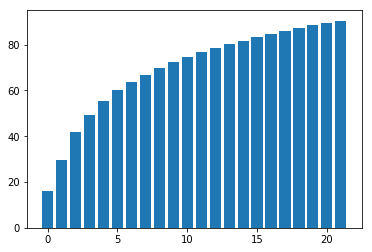

In [21]:
total = sum(pca.explained_variance_)
k = 0
current_variance = 0
while current_variance/total < 0.90:
    current_variance += pca.explained_variance_[k]
    k = k + 1
    
print(k, " features explain around 90% of the variance. From 7129 features to ", k, ", not too bad.", sep='')

pca = PCA(n_components=k)
X_train.pca = pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

var_exp = pca.explained_variance_ratio_.cumsum()
var_exp = var_exp*100
plt.bar(range(k), var_exp);

[]

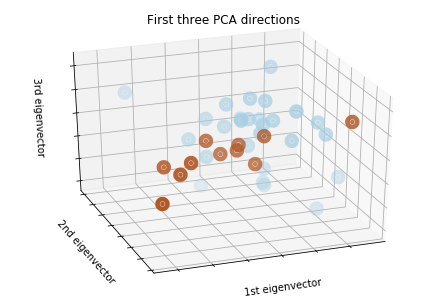

In [22]:
pca3 = PCA(n_components=3).fit(X_train)
X_train_reduced = pca3.transform(X_train)

plt.clf()
fig = plt.figure(1, figsize=(10,6 ))
ax = Axes3D(fig, elev=-150, azim=110,)
ax.scatter(X_train_reduced[:, 0], X_train_reduced[:, 1], X_train_reduced[:, 2], c = y_train.iloc[:,1], cmap = plt.cm.Paired, linewidths=10)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

Text(0.5, 1.0, '2D Transformation of the Above Graph ')

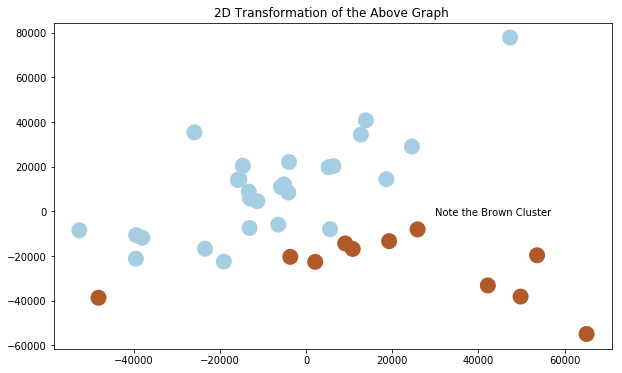

In [23]:
fig = plt.figure(1, figsize = (10, 6))
plt.scatter(X_train_reduced[:, 0],  X_train_reduced[:, 1], c = y_train.iloc[:,1], cmap = plt.cm.Paired, linewidths=10)
plt.annotate('Note the Brown Cluster', xy = (30000,-2000))
plt.title("2D Transformation of the Above Graph ")

In [24]:
print("Simply predicting everything as acute lymphoblastic leukemia (ALL) results in an accuracy of ", round(1 - np.mean(y_test.iloc[:,1]), 3), ".", sep = '')

Simply predicting everything as acute lymphoblastic leukemia (ALL) results in an accuracy of 0.588.


### K-Means

K-means accuracy: 0.765


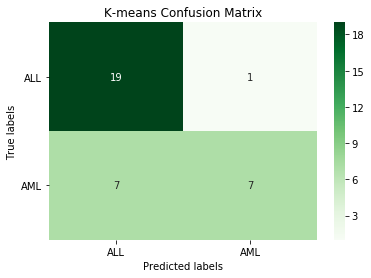

In [25]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_train_scl)
km_pred = kmeans.predict(X_test_scl)

print('K-means accuracy:', round(accuracy_score(y_test.iloc[:,1], km_pred), 3))

cm_km = confusion_matrix(y_test.iloc[:,1], km_pred)

ax = plt.subplot()
sns.heatmap(cm_km, annot=True, ax = ax, fmt='g', cmap='Greens') 

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('K-means Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

### Naive Bayes

Naive Bayes accuracy: 0.912


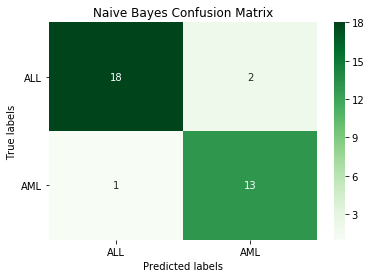

In [27]:
# Create a Gaussian classifier
nb_model = GaussianNB()

nb_model.fit(X_train, y_train.iloc[:,1])

nb_pred = nb_model.predict(X_test)

print('Naive Bayes accuracy:', round(accuracy_score(y_test.iloc[:,1], nb_pred), 3))

cm_nb =  confusion_matrix(y_test.iloc[:,1], nb_pred)

ax = plt.subplot()
sns.heatmap(cm_nb, annot=True, ax = ax, fmt='g', cmap='Greens') 

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Naive Bayes Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

In [28]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1 score
precision = precision_score(y_test.iloc[:,1], nb_pred)
recall = recall_score(y_test.iloc[:,1], nb_pred)
f1 = f1_score(y_test.iloc[:,1], nb_pred)

print('Precision:', round(precision, 3))
print('Recall:', round(recall, 3))
print('F1 Score:', round(f1, 3))

Precision: 0.867
Recall: 0.929
F1 Score: 0.897


### XGBoost

XGBoost accuracy: 0.912


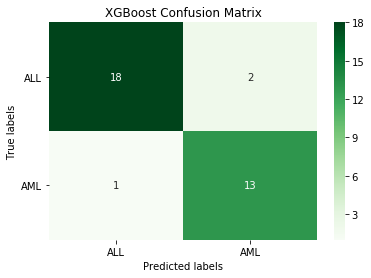

In [29]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create an XGBoost classifier
xgb_model = xgb.XGBClassifier()

# Fit the model
xgb_model.fit(X_train, y_train.iloc[:,1])

# Predict using the model
xgb_pred = xgb_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test.iloc[:,1], xgb_pred)
print('XGBoost accuracy:', round(accuracy, 3))

# Generate confusion matrix
cm_xgb = confusion_matrix(y_test.iloc[:,1], xgb_pred)

# Plot confusion matrix
ax = plt.subplot()
sns.heatmap(cm_xgb, annot=True, ax=ax, fmt='g', cmap='Greens')

# Labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('XGBoost Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=360)
plt.show()

In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1 score
precision = precision_score(y_test.iloc[:,1], xgb_pred)
recall = recall_score(y_test.iloc[:,1], xgb_pred)
f1 = f1_score(y_test.iloc[:,1], xgb_pred)

print('Precision:', round(precision, 3))
print('Recall:', round(recall, 3))
print('F1 Score:', round(f1, 3))

Precision: 0.867
Recall: 0.929
F1 Score: 0.897


### Random Forest

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForest accuracy: 0.794


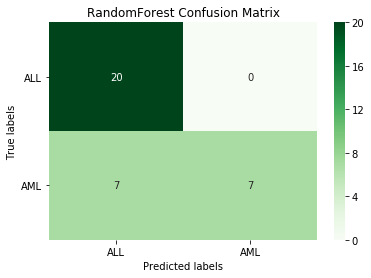

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create a RandomForest classifier
rf_model = RandomForestClassifier()

# Fit the model
rf_model.fit(X_train, y_train.iloc[:,1])

# Predict using the model
rf_pred = rf_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test.iloc[:,1], rf_pred)
print('RandomForest accuracy:', round(accuracy, 3))

# Generate confusion matrix
cm_rf = confusion_matrix(y_test.iloc[:,1], rf_pred)

# Plot confusion matrix
ax = plt.subplot()
sns.heatmap(cm_rf, annot=True, ax=ax, fmt='g', cmap='Greens')

# Labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('RandomForest Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=360)
plt.show()

In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1 score
precision = precision_score(y_test.iloc[:,1], rf_pred)
recall = recall_score(y_test.iloc[:,1], rf_pred)
f1 = f1_score(y_test.iloc[:,1], rf_pred)

print('Precision:', round(precision, 3))
print('Recall:', round(recall, 3))
print('F1 Score:', round(f1, 3))

Precision: 1.0
Recall: 0.5
F1 Score: 0.667


### AdaBoost

AdaBoost accuracy: 0.912


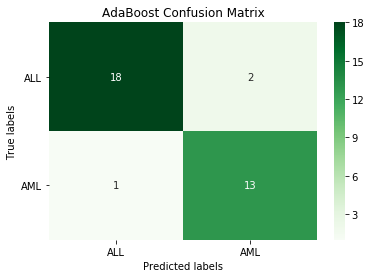

In [33]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create an AdaBoost classifier
adaboost_model = AdaBoostClassifier()

# Fit the model
adaboost_model.fit(X_train, y_train.iloc[:,1])

# Predict using the model
adaboost_pred = adaboost_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test.iloc[:,1], adaboost_pred)
print('AdaBoost accuracy:', round(accuracy, 3))

# Generate confusion matrix
cm_adaboost = confusion_matrix(y_test.iloc[:,1], adaboost_pred)

# Plot confusion matrix
ax = plt.subplot()
sns.heatmap(cm_adaboost, annot=True, ax=ax, fmt='g', cmap='Greens')

# Labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('AdaBoost Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=360)
plt.show()

In [34]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1 score
precision = precision_score(y_test.iloc[:,1], adaboost_pred)
recall = recall_score(y_test.iloc[:,1], adaboost_pred)
f1 = f1_score(y_test.iloc[:,1], adaboost_pred)

print('Precision:', round(precision, 3))
print('Recall:', round(recall, 3))
print('F1 Score:', round(f1, 3))

Precision: 0.867
Recall: 0.929
F1 Score: 0.897


### KNN

KNN accuracy: 0.824


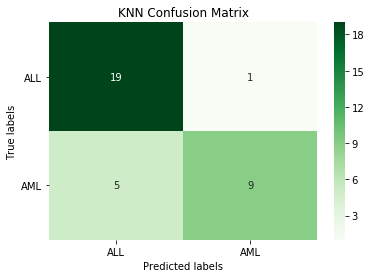

In [35]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create a KNN classifier
knn_model = KNeighborsClassifier()

# Fit the model
knn_model.fit(X_train, y_train.iloc[:,1])

# Predict using the model
knn_pred = knn_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test.iloc[:,1], knn_pred)
print('KNN accuracy:', round(accuracy, 3))

# Generate confusion matrix
cm_knn = confusion_matrix(y_test.iloc[:,1], knn_pred)

# Plot confusion matrix
ax = plt.subplot()
sns.heatmap(cm_knn, annot=True, ax=ax, fmt='g', cmap='Greens')

# Labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('KNN Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=360)
plt.show()


In [36]:
# Calculate precision, recall, and F1 score
precision = precision_score(y_test.iloc[:,1], knn_pred)
recall = recall_score(y_test.iloc[:,1], knn_pred)
f1 = f1_score(y_test.iloc[:,1], knn_pred)

print('Precision:', round(precision, 3))
print('Recall:', round(recall, 3))
print('F1 Score:', round(f1, 3))

Precision: 0.9
Recall: 0.643
F1 Score: 0.75


### Logistic Regression

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Parameters:
 {'C': 1, 'penalty': 'l1'}
Logistic Regression accuracy: 1.0


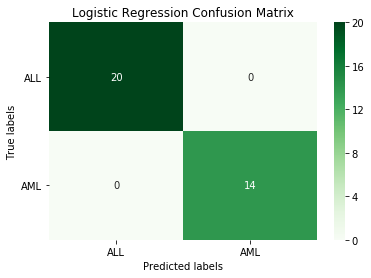

In [37]:
log_grid = {'C': [1e-03, 1e-2, 1e-1, 1, 10], 
                 'penalty': ['l1', 'l2']}

log_estimator = LogisticRegression(solver='liblinear')

log_model = GridSearchCV(estimator=log_estimator, 
                  param_grid=log_grid, 
                  cv=3,
                  scoring='accuracy')

log_model.fit(X_train, y_train.iloc[:,1])

print("Best Parameters:\n", log_model.best_params_)

# Select best log model
best_log = log_model.best_estimator_

# Make predictions using the optimised parameters
log_pred = best_log.predict(X_test)

print('Logistic Regression accuracy:', round(accuracy_score(y_test.iloc[:,1], log_pred), 3))

cm_log =  confusion_matrix(y_test.iloc[:,1], log_pred)

ax = plt.subplot()
sns.heatmap(cm_log, annot=True, ax = ax, fmt='g', cmap='Greens') 

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Logistic Regression Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

In [38]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1 score
precision = precision_score(y_test.iloc[:,1], log_pred)
recall = recall_score(y_test.iloc[:,1], log_pred)
f1 = f1_score(y_test.iloc[:,1], log_pred)

print('Precision:', round(precision, 3))
print('Recall:', round(recall, 3))
print('F1 Score:', round(f1, 3))

Precision: 1.0
Recall: 1.0
F1 Score: 1.0


### SVM

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Parameters:
 {'C': 0.1, 'decision_function_shape': 'ovo', 'gamma': 1, 'kernel': 'linear'}
SVM accuracy: 0.941


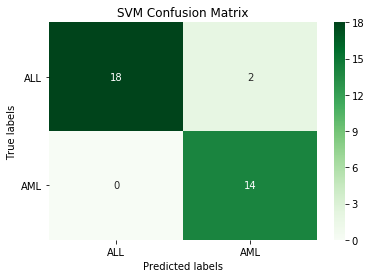

In [39]:
# Parameter grid
svm_param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001, 0.00001, 10], "kernel": ["linear", "rbf", "poly"], "decision_function_shape" : ["ovo", "ovr"]} 

# Create SVM grid search classifier
svm_grid = GridSearchCV(SVC(), svm_param_grid, cv=3)

# Train the classifier
svm_grid.fit(X_train_pca, y_train.iloc[:,1])

print("Best Parameters:\n", svm_grid.best_params_)

# Select best svc
best_svc = svm_grid.best_estimator_

# Make predictions using the optimised parameters
svm_pred = best_svc.predict(X_test_pca)

print('SVM accuracy:', round(accuracy_score(y_test.iloc[:,1], svm_pred), 3))

cm_svm =  confusion_matrix(y_test.iloc[:,1], svm_pred)

ax = plt.subplot()
sns.heatmap(cm_svm, annot=True, ax = ax, fmt='g', cmap='Greens') 

# Labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('SVM Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

In [40]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1 score
precision = precision_score(y_test.iloc[:,1], svm_pred)
recall = recall_score(y_test.iloc[:,1], svm_pred)
f1 = f1_score(y_test.iloc[:,1], svm_pred)

print('Precision:', round(precision, 3))
print('Recall:', round(recall, 3))
print('F1 Score:', round(f1, 3))

Precision: 0.875
Recall: 1.0
F1 Score: 0.933


In [41]:
# Create model architecture
model = Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(7129,)))
model.add(layers.Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.


In [42]:
# Compile model
model.compile(optimizer='adam',
loss='binary_crossentropy',
metrics=['accuracy'])

In [43]:
# Create training/validation sets
partial_X_train = X_train_scl[:30]
X_val = X_train_scl[30:]

y_train_label = y_train.iloc[:,1]
partial_y_train = y_train_label[:30]
y_val = y_train_label[30:]

In [44]:
# Set up early stopping
es = callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=3)

# Fit model
history = model.fit(partial_X_train,
            partial_y_train,
            epochs=50,
            batch_size=4,
            validation_data=(X_val, y_val),
            callbacks=[es])

Instructions for updating:
Use tf.cast instead.
Train on 30 samples, validate on 8 samples
Epoch 1/50
30/30 [==============================] - 0s 16ms/step - loss: 0.3600 - acc: 0.8000 - val_loss: 0.1942 - val_acc: 0.8750
Epoch 2/50
30/30 [==============================] - 0s 2ms/step - loss: 0.0058 - acc: 1.0000 - val_loss: 0.1833 - val_acc: 0.8750
Epoch 3/50
30/30 [==============================] - 0s 1ms/step - loss: 4.8213e-04 - acc: 1.0000 - val_loss: 0.1892 - val_acc: 0.8750
Epoch 4/50
30/30 [==============================] - 0s 1ms/step - loss: 2.5228e-04 - acc: 1.0000 - val_loss: 0.1897 - val_acc: 0.8750
Epoch 5/50
30/30 [==============================] - 0s 1ms/step - loss: 1.3106e-04 - acc: 1.0000 - val_loss: 0.1891 - val_acc: 0.8750
Epoch 00005: early stopping


Neural Network accuracy:  0.765


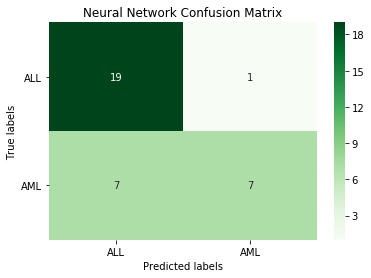

In [45]:
# Make predictions
nn_pred = model.predict_classes(X_test_scl)

print('Neural Network accuracy: ', round(accuracy_score(y_test.iloc[:,1], nn_pred), 3))

cm_nn = confusion_matrix(y_test.iloc[:,1], nn_pred)

ax = plt.subplot()
sns.heatmap(cm_nn, annot=True, ax = ax, fmt='g', cmap='Greens') 

# Labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Neural Network Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

# Explanation

#### Using Logistic Regression Model

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Parameters:
 {'C': 10, 'penalty': 'l1'}
Logistic Regression accuracy: 1.0


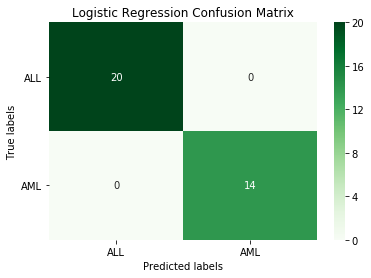

In [47]:
log_grid = {'C': [1e-03, 1e-2, 1e-1, 1, 10], 
                 'penalty': ['l1', 'l2']}

log_estimator = LogisticRegression(solver='liblinear')

log_model = GridSearchCV(estimator=log_estimator, 
                  param_grid=log_grid, 
                  cv=3,
                  scoring='accuracy')

log_model.fit(X_train, y_train.iloc[:,1])

print("Best Parameters:\n", log_model.best_params_)

# Select best log model
best_log = log_model.best_estimator_

# Make predictions using the optimised parameters
log_pred = best_log.predict(X_test)

print('Logistic Regression accuracy:', round(accuracy_score(y_test.iloc[:,1], log_pred), 3))

cm_log =  confusion_matrix(y_test.iloc[:,1], log_pred)

ax = plt.subplot()
sns.heatmap(cm_log, annot=True, ax = ax, fmt='g', cmap='Greens') 

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Logistic Regression Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

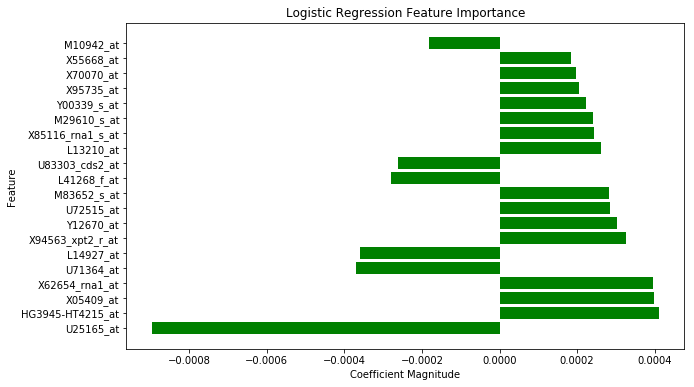

In [52]:
# Extract feature importance (coefficients)
feature_importance = best_log.coef_[0]

# Match feature importance with feature names
feature_names = X_train.columns.tolist()
feature_importance_dict = dict(zip(feature_names, feature_importance))

# Sort feature importance
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: abs(x[1]), reverse=True)
top_features = sorted_feature_importance[:20]

# Print feature importance
# print("Feature Importance:")
# for feature, importance in sorted_feature_importance:
#     print(f"{feature}: {importance}")

# If you want to visualize feature importance, you can create a bar plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh([x[0] for x in top_features], [x[1] for x in top_features], color='green')
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Feature')
plt.title('Logistic Regression Feature Importance')
plt.show()

Feature Importance:

Total feature with +/- importance 711


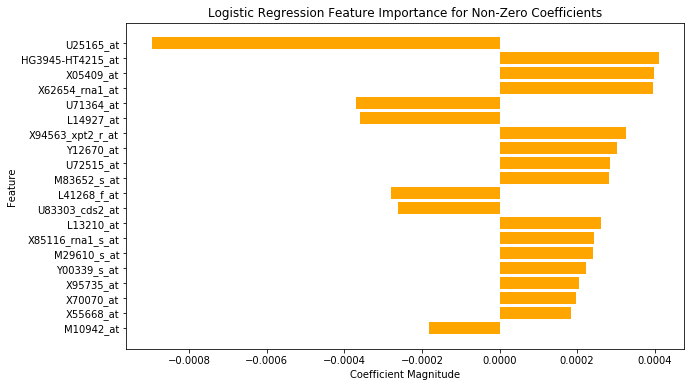

In [53]:
# Assuming 'best_log' is your trained Logistic Regression model and X_train has been defined
feature_importance = best_log.coef_[0]
feature_names = X_train.columns.tolist()

# Create a dictionary of feature names and their importance
feature_importance_dict = dict(zip(feature_names, feature_importance))

# Filter out features with zero importance and sort the rest
non_zero_importance = {feature: imp for feature, imp in feature_importance_dict.items() if imp != 0}
sorted_feature_importance = sorted(non_zero_importance.items(), key=lambda x: abs(x[1]), reverse=True)
top_features = sorted_feature_importance[:20]

# Print feature importance
print("Feature Importance:")
# for feature, importance in sorted_feature_importance:
#     print(f"{feature}: {importance}")

# Visualization of non-zero feature importance
import matplotlib.pyplot as plt
print("\nTotal feature with +/- importance",len(sorted_feature_importance))

plt.figure(figsize=(10, 6))
plt.barh([x[0] for x in top_features], [x[1] for x in top_features], color='orange')
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Feature')
plt.title('Logistic Regression Feature Importance for Non-Zero Coefficients')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()


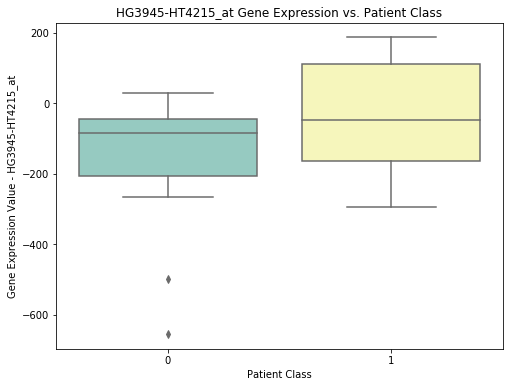

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Y_test = y_test.iloc[:,1]

# Extract gene expression values and class labels
gene_expression_values = X_test["HG3945-HT4215_at"].values.flatten()  # Extracting values and flattening to 1D
class_labels = Y_test  # AML or ALL class labels for each patient

# Create a DataFrame for easier plotting (optional)
data = pd.DataFrame({'Gene Expression': gene_expression_values, 'Class': class_labels})
sns.set_palette("Set3", 10)

# Create a box plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Class', y='Gene Expression', data=data)
plt.xlabel('Patient Class')
plt.ylabel('Gene Expression Value - HG3945-HT4215_at')
plt.title('HG3945-HT4215_at Gene Expression vs. Patient Class')
plt.show()

# Clustering

In [67]:
target_names = ['ALL','AML']

K-means accuracy: 0.765
K-means precision: 0.875
K-means recall: 0.5
K-means F1-score: 0.636


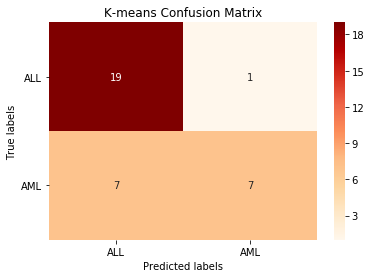

In [69]:
kmeans = KMeans(n_clusters=2, random_state=0,max_iter=1000).fit(X_train_scl)
km_pred = kmeans.predict(X_test_scl)

precision = precision_score(Y_test, km_pred)
recall = recall_score(Y_test, km_pred)
f1 = f1_score(Y_test, km_pred)

print('K-means accuracy:', round(accuracy_score(Y_test, km_pred), 3))
print('K-means precision:', round(precision, 3))
print('K-means recall:', round(recall, 3))
print('K-means F1-score:', round(f1, 3))

cm_km = confusion_matrix(Y_test, km_pred)

ax = plt.subplot()
sns.heatmap(cm_km, annot=True, ax = ax, fmt='g', cmap='OrRd')

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('K-means Confusion Matrix')
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names, rotation=360);

Agglomerative Clustering accuracy: 0.647
Agglomerative Clustering precision: 0.583
Agglomerative Clustering recall: 0.5
Agglomerative Clustering F1-score: 0.538


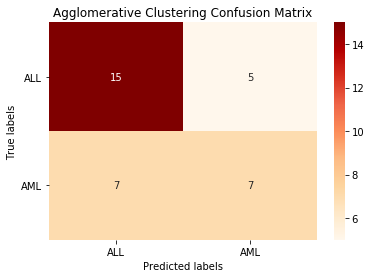

In [70]:
from sklearn.cluster import AgglomerativeClustering

agg_clustering = AgglomerativeClustering(n_clusters=2).fit(X_train)
agg_pred = agg_clustering.fit_predict(X_test)

precision = precision_score(Y_test, agg_pred)
recall = recall_score(Y_test, agg_pred)
f1 = f1_score(Y_test, agg_pred)

print('Agglomerative Clustering accuracy:', round(accuracy_score(Y_test, agg_pred), 3))
print('Agglomerative Clustering precision:', round(precision, 3))
print('Agglomerative Clustering recall:', round(recall, 3))
print('Agglomerative Clustering F1-score:', round(f1, 3))

cm_agg = confusion_matrix(Y_test, agg_pred)

ax = plt.subplot()
sns.heatmap(cm_agg, annot=True, ax=ax, fmt='g', cmap='OrRd')

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Agglomerative Clustering Confusion Matrix')
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names, rotation=360);

/opt/conda/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/opt/conda/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Spectral Clustering accuracy: 0.559
Spectral Clustering precision: 0.48
Spectral Clustering recall: 0.857
Spectral Clustering F1-score: 0.615


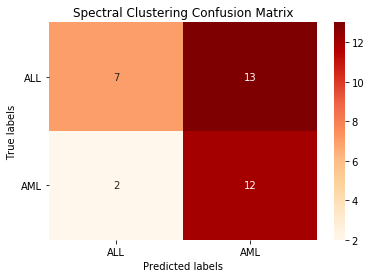

In [71]:
from sklearn.cluster import SpectralClustering

# Spectral clustering
spectral = SpectralClustering(n_clusters=2, random_state=0, n_init=7)
spectral.fit(X_train)
spectral_pred = spectral.fit_predict(X_test)

precision = precision_score(Y_test, spectral_pred)
recall = recall_score(Y_test, spectral_pred)
f1 = f1_score(Y_test, spectral_pred)

print('Spectral Clustering accuracy:', round(accuracy_score(Y_test, spectral_pred), 3))
print('Spectral Clustering precision:', round(precision, 3))
print('Spectral Clustering recall:', round(recall, 3))
print('Spectral Clustering F1-score:', round(f1, 3))

cm_spectral = confusion_matrix(Y_test, spectral_pred)

ax = plt.subplot()
sns.heatmap(cm_spectral, annot=True, ax=ax, fmt='g', cmap='OrRd')

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Spectral Clustering Confusion Matrix')
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names, rotation=360);